# Projet de Séries Chronologiques - Master 2 Data Science - Novembre 2022/Janvier 2023
## Étude de démographie - Naissances vivantes en France métropolitaine de 1974 à 2021

Bencheikh Meriem, Douarec Chloé et Lesage Solène

## Packages et Fonctions programmées utiles pour la suite

### Importation des packages

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [50]:
# Packages classiques
import numpy as np
import pandas as pd
from scipy.stats import norm

# Graphiques
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import seaborn as sns
from seaborn.utils import ci
sns.set()
#pd.options.plotting.backend = "plotly"

# statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

# sklearn
from sklearn.metrics import *

# scipy
from scipy.stats import shapiro

#pip install pmdarima
import pmdarima as pm

# Pour que les graphes plotly s'affichent lorsqu'on exporte en HTML
#import plotly.io as pio
#pio.renderers.default = 'iframe'

### Fonction checkup_res

In [3]:
def checkup_res(res):  
    """
    Fonction permettant de réaliser un checkup des résidus
    """
      
    res = res.dropna()
    
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    ax7 = fig.add_subplot(gs[2, 2])

    # Residuals' plot
    sns.lineplot(data=res, ax=ax1).set(xlabel="", ylabel="", title='')
    
    # ACF
    plot_acf(res, ax=ax2)

    # PACF
    plot_pacf(res, ax=ax3)

    # Lag
    sns.scatterplot(x=res.values[:-1], y=res.values[1:], ax=ax4).set(xlabel=r'$\epsilon_{t-1}$', ylabel=r'$\epsilon_t$', title='Lag 1')

    # Histogramme
    sns.histplot(res / res.std(), stat="density", ax=ax5).set(title='Standardized residuals histplot', xlabel="")
    x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
    ax5.plot(x, norm.pdf(x),'r--', label='N(0,1)')

    # QQ plot
    qqplot(res / res.std(), line='45', ax=ax6)
    ax6.title.set_text('QQ Plot')

    # Série normalisée
    res_norm = (res.values - res.mean()) / res.std()
    sns.scatterplot(data=res_norm, ax=ax7).set(title="Normalised residuals", xlabel='Time')
    sns.lineplot(x=range(len(res_norm)), y=1.96, color="r", linestyle='--', ax=ax7)
    sns.lineplot(x=range(len(res_norm)), y=-1.96, color="r", linestyle='--', ax=ax7)

    # Paramètres graphiques et affichage
    plt.suptitle("Residuals' checkup")
    plt.tight_layout()
    plt.show()

## Présentation et visualisation des données

**Description de la série** 

La série que l'on souhaite étudier est une série en démographie. Elle permet de visualiser le nombre de naissances vivantes en France métropolitaine de 1946 à 2022.



### Chargement des données

In [4]:
# Chargement des données
ts=pd.read_csv("sample_data/vm1.csv", sep=";")
ts=ts.rename(columns={"Démographie - Nombre de naissances vivantes - France métropolitaine":"Naissances"})

In [5]:
# Transformation des données en série temporelle/chronologique (time series)
ts["Date"] = pd.to_datetime(ts['Libellé']).dt.strftime('%m-%Y')
ts=ts.drop(['Libellé','Codes'], axis=1)
ts=ts.set_index('Date')
ts

,Naissances
Date,
01-1946,64599
02-1946,65702
03-1946,78294
04-1946,76400
05-1946,76636
...,...
06-2022,58300
07-2022,61400
08-2022,60800


### Visualisation de la série chronologique

In [6]:
fig = go.Figure(data=go.Scatter(y=ts["Naissances"], x=ts.index, mode='lines', line=dict(color='#CE8E0F', width=1)))

fig.update_layout(
    title=f'Nombre de naissances vivantes de {ts.index[0]} à {ts.index[-1]} en France Métropolitaine',
    showlegend=False, 
    yaxis=dict(title_text='Nombre de naissances',tickvals=np.arange(50000,83000,4000), 
              titlefont=dict(size=15),titlefont_size=16,tickfont_size=14),
    xaxis=dict(title_text="Date",titlefont=dict(size=15),tickfont_size=14,),
    margin=dict(l=50, r=20, t=60, b=10), 
    paper_bgcolor="white",           
    plot_bgcolor="#FFFCF2")

fig.show()

## Pré-traitement de la série

### Passage au log

On décide de réaliser un passage de la série au logarithme, pour obtenir une modélisation additive et diminuer l’ordre de grandeur de la série. En effet, la valeur maximale est au-delà de 80k, et la minimale est près de 51k : on est sur une très grande échelle avec des écarts importants entre les valeurs prises par la série.

In [7]:
# Passage au log
Lts=np.log(ts)

In [8]:
fig = go.Figure(data=go.Scatter(y=Lts["Naissances"], x=Lts.index, mode='lines', line=dict(color='#AE257C', width=1)))

fig.update_layout(
    title=f'Visualisation de la série après passage au logarithme',
    showlegend=False, 
    yaxis=dict(title_text='Nombre de naissances', tickvals=np.arange(10.5,12,0.1), 
               titlefont=dict(size=15), titlefont_size=16, tickfont_size=14,),
    xaxis=dict(title_text="Date",titlefont=dict(size=15),tickfont_size=14,),
    margin=dict(l=50, r=20, t=60, b=10),  # marges du graphique
    paper_bgcolor="white",                # couleur de fond
    plot_bgcolor="#FFF4FF")

fig.show()

### Troncature de la série

Pour obtenir une meilleure modélisation et donc prédiction, on tronque la série de janvier 1974 jusqu'à décembre 2021, étant donné qu'il y a une différence entre les valeurs moyennes prises sur la première partie de la série, et sur cette deuxième partie que nous décidons de garder.

In [9]:
print("Moyenne de la première partie :",float(ts.loc[:'12-1973'].mean()),"\nMoyenne de la deuxième partie :",float(ts.loc['01-1974':'12-2021'].mean()))

Moyenne de la première partie : 70258.89583333333 
Moyenne de la deuxième partie : 63245.49652777778


In [10]:
# Tronquer la série
tsT=Lts.loc['01-1974':'12-2021']

In [11]:
fig = go.Figure(data=go.Scatter(y=tsT["Naissances"], x=tsT.index, mode='lines', line=dict(color='#AE257C', width=1)))

fig.update_layout(
    title=f'Visualisation de la série tronquée',
    showlegend=False, 
    yaxis=dict(title_text='Nombre de naissances',tickvals=np.arange(10.5,12,0.1), 
        titlefont=dict(size=15),titlefont_size=16,tickfont_size=14),
    xaxis=dict(title_text="Date",titlefont=dict(size=15),tickfont_size=14),
    margin=dict(l=50, r=20, t=60, b=10), paper_bgcolor="white", plot_bgcolor="#FFF4FF")

fig.show()

### Recherche et traitement des données manquantes et des outliers.

#### Données manquantes

In [12]:
print(tsT.isnull().sum())

Naissances    0
dtype: int64


Il n'y a aucune donnée manquante sur la série tronquée.

#### Données aberrantes

Recherche visuelle des éventuelles données aberrantes en utilisant un boxplot

In [13]:
fig = go.Figure()
fig.add_traces(go.Box(y=tsT["Naissances"], name="Log(Nombre de naissances)", text=tsT.index, 
                      marker_color='#3875a9', boxmean=True, notched=True, boxpoints='outliers'))

fig.update_layout(xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(title_text="Valeurs", dtick=0.05, titlefont=dict(size=15), gridcolor='white'),
                title_text="Boxplot du log de la série tronquée", height=600,width=350,
                margin=dict(l=50, r=50, t=60, b=50), paper_bgcolor="white", plot_bgcolor="#f9ffff",)
fig.show()

Récupération des outliers détectés dans un dataframe

In [14]:
def find_outliers(df):
    """
    Récupération des outliers du dataframe df avec l'écart interquartile
    """
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1

    borne_inf=q1-1.5*IQR
    borne_sup=q3+1.5*IQR

    outliers = df[((df<borne_inf) | (df>borne_sup))]

    return outliers.dropna(),borne_inf, borne_sup

outliers, borne_inf, borne_sup = find_outliers(tsT)
outliers

,Naissances
Date,
02-1993,10.886539
02-1994,10.876178
02-1995,10.886951
02-2018,10.872997
02-2019,10.855763
02-2020,10.887699
01-2021,10.843299
02-2021,10.803832


In [15]:
print("Les outliers détectés correspondent à un nombre de naissances inférieur à",int(np.exp(borne_inf)),"par mois")

Les outliers détectés correspondent à un nombre de naissances inférieur à 53672 par mois


Les outliers détectés par le boxplot sont toutes des valeurs mesurées sur des mois de février à compter de 1993, et une autre mesurée en janvier 2021. Cela semble donc ne pas être des valeurs aberrantes mais uniquement des valeurs extrêmes à l'échelle de toute la série tronquée. Cela correspond plutôt à des extrêmes annuels où il semble y avoir moins de naissances au mois de février depuis 30 ans à compter d'aujourd'hui. Il faut donc garder ces données qui fournissent de l'information.

## Décomposition de la série : identification de la période et étude de la stationnarité

### Identification de la période

On recherche la période exacte de la série avec l'aide de la transformée de Fourier rapide (FFT)

In [16]:
from scipy import signal
from numpy.fft import fft, fftfreq, ifft

n=len(tsT)
freqs=fftfreq(n)
#mask = freqs>0 # On ne choisit que les fq positives 

# On applique une fft sur la série tronquée
fft_values=fft(tsT)
fft_list=np.copy(fft_values).tolist()

# On copie le fft original afin de pouvoir le filtrer
fft_filtered=np.copy(fft_list).tolist()
print(np.max(np.real(fft_filtered)))    # On prend une freq = 11 

nobs = len(tsT)
ft = np.abs(np.fft.rfft(tsT))
freq = np.fft.rfftfreq(nobs)
print(len(ft), len(freq))

11.211604132591996
576 289


In [17]:
reverse=np.real(ifft(fft_filtered))
reverse=pd.DataFrame(reverse,columns=["Facteur Saisonnier"])
reverse

,Facteur Saisonnier
0,11.130332
1,11.014094
2,11.147267
3,11.154964
4,11.210874
...,...
571,11.040375
572,11.031238
573,11.060982
574,10.999697


In [18]:
fig_reversefft = go.Figure(data=go.Scatter( y=reverse["Facteur Saisonnier"], x=tsT.index, mode='lines', line=dict(color='#4057AC', width=1)))

fig_reversefft.update_layout(
    title="Reverse fft", showlegend=False, 
    yaxis=dict(title_text='Facteur saisonnier', titlefont_size=16, tickfont_size=14,),
    xaxis=dict(title_text="Temps", titlefont_size=15, tickfont_size=14),
    margin=dict(l=50, r=20, t=60, b=10), paper_bgcolor="white", plot_bgcolor="#F1F4FF")

fig_reversefft.show()

## Etude de la stationnarité


Pour appliquer les modèles ARMA, la série doit être supposée stationnaire. 
Pour vérifier cette hypothèse de stationnarité, nous allons appliquer les tests de stationnarité ADF (Augmented Dickey Fuller) et KPSS (Kwiatkowski–Phillips–Schmidt–Shin). Le test ADF a pour hypothèse nulle la non-stationnarité de la série testée, tandis que le test KPSS a pour hypothèse nulle la stationnarité de celle-ci. Ce sont donc deux tests complémentaires.


In [19]:
import warnings
warnings.filterwarnings("ignore")

# ADF Test
#y=decomp_log.resid.dropna()
result = adfuller(tsT, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# KPSS Test
result = kpss(tsT, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Ljung-Box Test
#result = sm.stats.acorr_ljungbox(y.values, lags=[72], return_df=False)
##print('\nLjung-Box Statistic: %f' % result[0][0])
#print('p-value: %f' % result[1][0])


ADF Statistic: -3.622448281765694
p-value: 0.005346085832729423

KPSS Statistic: 0.278541
p-value: 0.100000


Pour le test ADF, dont l'hypothèse nulle H0 testée est la non-stationnarité de la série, donne une p-value de $0.0053 < 0.05$. On rejete donc l'hypothèse que la série ne soit pas stationnaire à un risque de $5$% avec le test ADF.<br>
De plus, le test KPSS, dont l'hypothèse H0 est la stationnarité de la série, donne une p-value de $0.1 > 0.05$. On ne peut donc rejeter l'hypothèse nulle, et donc que la série soit stationnaire.<br>
En conclusion, les deux tests ADF et KPSS s'accordent sur l'hypothèse de stationnarité de la série au seuil de $0.05$.<br>

Cependant, d'un point de vue graphique, la série ne semble pas clairement stationnaire. Cela s'explique notamment par le fait que l'on a une forte saisonnalité. On ne peut donc pas se fier aux résultats des tests ADF et KPSS.<br> 
On va donc étudier la saisonnalité de la série, et chercher à l'éliminer via une différenciation, pour arriver à une stationnarité plus nette.

## Saisonnalité

En raison de la présence d'une forte saisonnalité, nous allons analyser visuellement l'ACF (Fonction d'autocorrélation) et la PACF (Fonction d'autocorrélation partielle) de notre série temporelle. Ce sont deux outils fondamentaux dans l'étude des modèles ARMA. <br> 
L'ACF permet de mesurer la corrélation entre des observations de la série qui sont séparées par $k$ unités de temps ($X_t$ et $X_{t-k}$).<br> L'autocorrélation partielle (PACF) permet de quantifier la dépendance linéaire entre deux observations séparées par $k$ unités de temps, mais conditionnellement aux observations intermédiaires.

### Analyse visuelle de l'ACF et PACF de la série

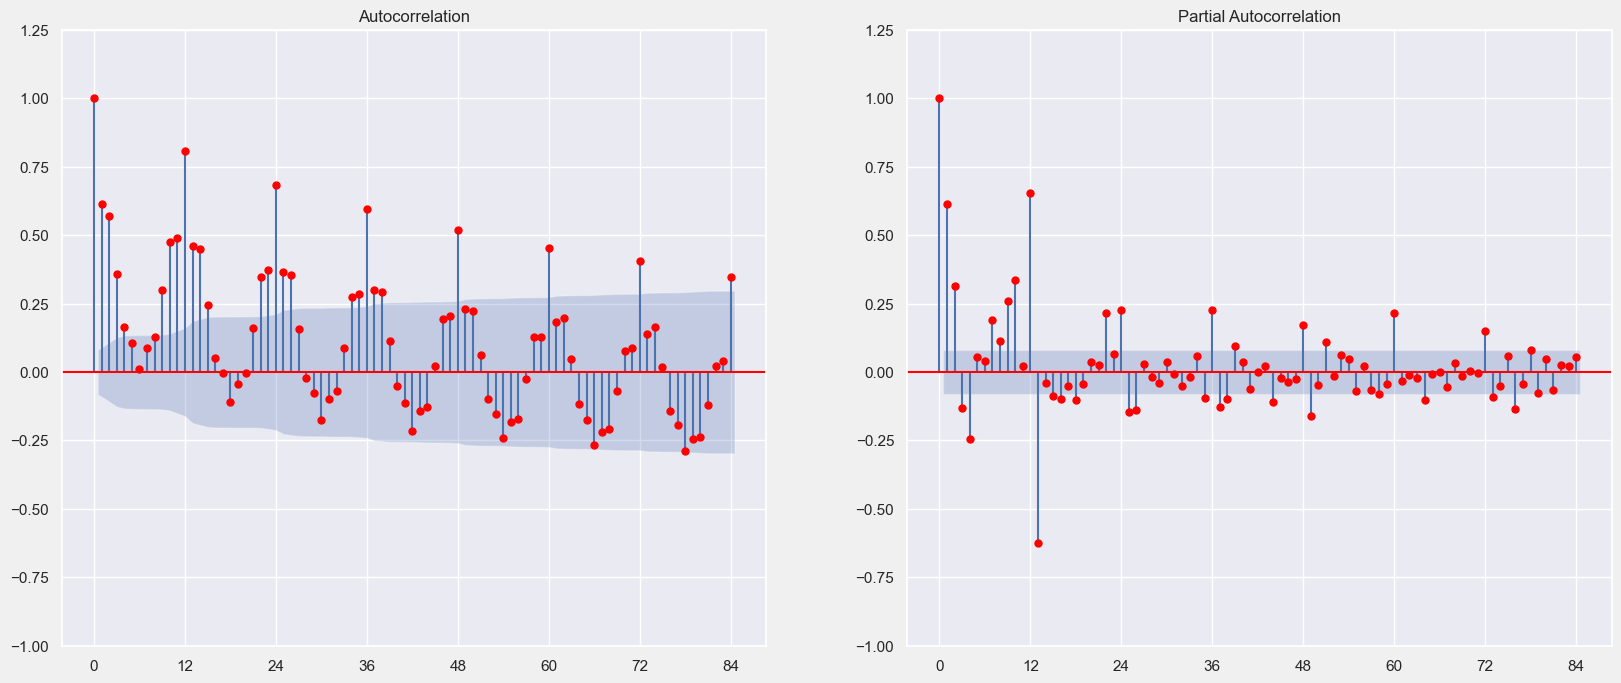

In [20]:
#Analyse de l'ACF et la PACF
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, facecolor="#F0F0F0", figsize=(20 ,8))

#ACF
plot_acf(tsT, lags=84, alpha=0.05, ax=ax1, color='red')
ax1.set_xticks(np.arange(0,86,12))
ax1.set_yticks(np.arange(-1,1.3,0.25))

#PACF
plot_pacf(tsT, lags=84, alpha=0.05, ax=ax2, color='red')
ax2.set_xticks(np.arange(0,86,12))
ax2.set_yticks(np.arange(-1,1.3,0.25))

fig.show()

L'ACF montre plusieurs pics significatifs ce qui traduit le fait qu'il y ait une forte corrélation entre les lags ou décalages dans le temps. De plus, elle montre la présence d'une saisonnalité au lags multiples de 12.<br>
La PACF présente quelques pics significatifs au niveau des premiers lags, suivis d'un motif en vague atténué, qui alterne entre corrélations positives et négatives. On remarque encore une fois la présence de pics significatifs à tous les lags multiples de 12.<br>
On en déduit que la série semble avoir une période de 12, c'est à dire qu'on a un motif qui se repète toutes les 12 observations. Autrement dit pour notre série, une année équivaut à une période, puisque les observations sont réalisées tous les mois.
Nous allons alors différencier la série afin d'éliminer la tendance saisonnière, en prenant en compte la période de la série. 

### Différenciation de la série

Désormais, l'objectif est d'éliminer la tendance saisonnière. Pour cela, on essaie une première différenciation de la série $X_t$.

#### Différenciation simple

On teste d'abord avec une seule différenciation avec une période de 12, puisqu'on possède des données mensuelles, de saisonnalité annuelle. Cela revient à tester les paramètres $d=0$ et $D=1$ pour le futur modèle.

Afin d'éliminer la tendance saisonnière, on va appliquer un filtre de la forme $(I-B^{12})$ où $B$ désigne l'opérateur retard, qui à une donnée chronologique associe sa valeur précédente dans le temps, et on regarde alors si $ΔX_t = (I-B^{12}) X_t$ est stationnaire.

In [21]:
# 1ère Différentiation avec période de 12 : on teste d=0 et D=1.
DataDiffS1 = tsT.diff(12).dropna() 

# Représentation graphique
fig1 = go.Figure(data=go.Scatter(y=DataDiffS1["Naissances"], x=DataDiffS1.index, mode='lines',line=dict(color='#337D4E', width=1)))

fig1.update_layout(
    title="Première différenciation de la série (d=0 et D=1)",showlegend=False, 
    yaxis=dict(title_text='Valeurs',titlefont=dict(size=15),titlefont_size=16,tickfont_size=14),
    xaxis=dict(title_text="Date", titlefont=dict(size=15), tickfont_size=14),
    margin=dict(l=50, r=20, t=50, b=10),paper_bgcolor="white",plot_bgcolor="#ECFCF3")

fig1.show()

On regarde ce que cette différenciation nous donne comme résultats avec les tests ADF et KPSS.

In [22]:
# ADF Test
result = adfuller(DataDiffS1, autolag='AIC') 
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# KPSS Test
result = kpss(DataDiffS1, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.039893634398145
p-value: 1.84931412610279e-05

KPSS Statistic: 0.105654
p-value: 0.100000


La p-value du test ADF est de l'ordre de $10^{-5}$ et est donc très faible, et celle du test KPSS vaut $0.10 > 0.05$. Avec le test ADF, on rejette donc l'hypothèse nulle de non stationnarité de la série. Quand à lui, le test KPSS mène à la conclusion que l'on ne peut pas rejetter l'hypothèse que la série soit stationnaire.<br>
Les tests ADF et KPSS ne se contredisent pas, et mène tous les deux à la même conclusion : la série considérée semble stationnaire avec un risque de 5%. 
Graphiquement cela semble cohérent mais ce n'est pas totalement convaincant non plus. On va donc réaliser une double différenciation de la série et comparer les résultats graphiquement.

#### Double différenciation

Essayons de différencier à nouveau la série initiale $X_t$ en lui appliquant le filtre $(I-B)(I-B^{12})$.

In [23]:
# 2ème Différentiation : on teste d=1 et D=1.
DataDiffS2 = tsT.diff(12).diff().dropna()

##### Analyse visuelle

In [24]:
fig2 = go.Figure(data=go.Scatter(y=DataDiffS2["Naissances"], x=DataDiffS2.index, mode='lines', line=dict(color='#337D4E', width=1)))

fig2.update_layout(
    title="Double différenciation de la série (d=1 et D=1)", showlegend=False, 
    yaxis=dict(title_text='Valeurs', titlefont=dict(size=15), titlefont_size=16, tickfont_size=14),
    xaxis=dict(title_text="Date", titlefont=dict(size=15), tickfont_size=14),
    margin=dict(l=50, r=20, t=50, b=10), paper_bgcolor="white", plot_bgcolor="#ECFCF3")

fig2.show()

Avec cette double différenciation, la stationnarité de la série est désormais claire graphiquement. On ne réalise pas à nouveau les tests ADF et KPSS, puisqu'ils menaient déjà à une conclusion de stationnarité avec un risque de 5% lors de la première différenciation.

##### Décomposition de la série :
D'abord, faisons une décomposition de la série différenciée.

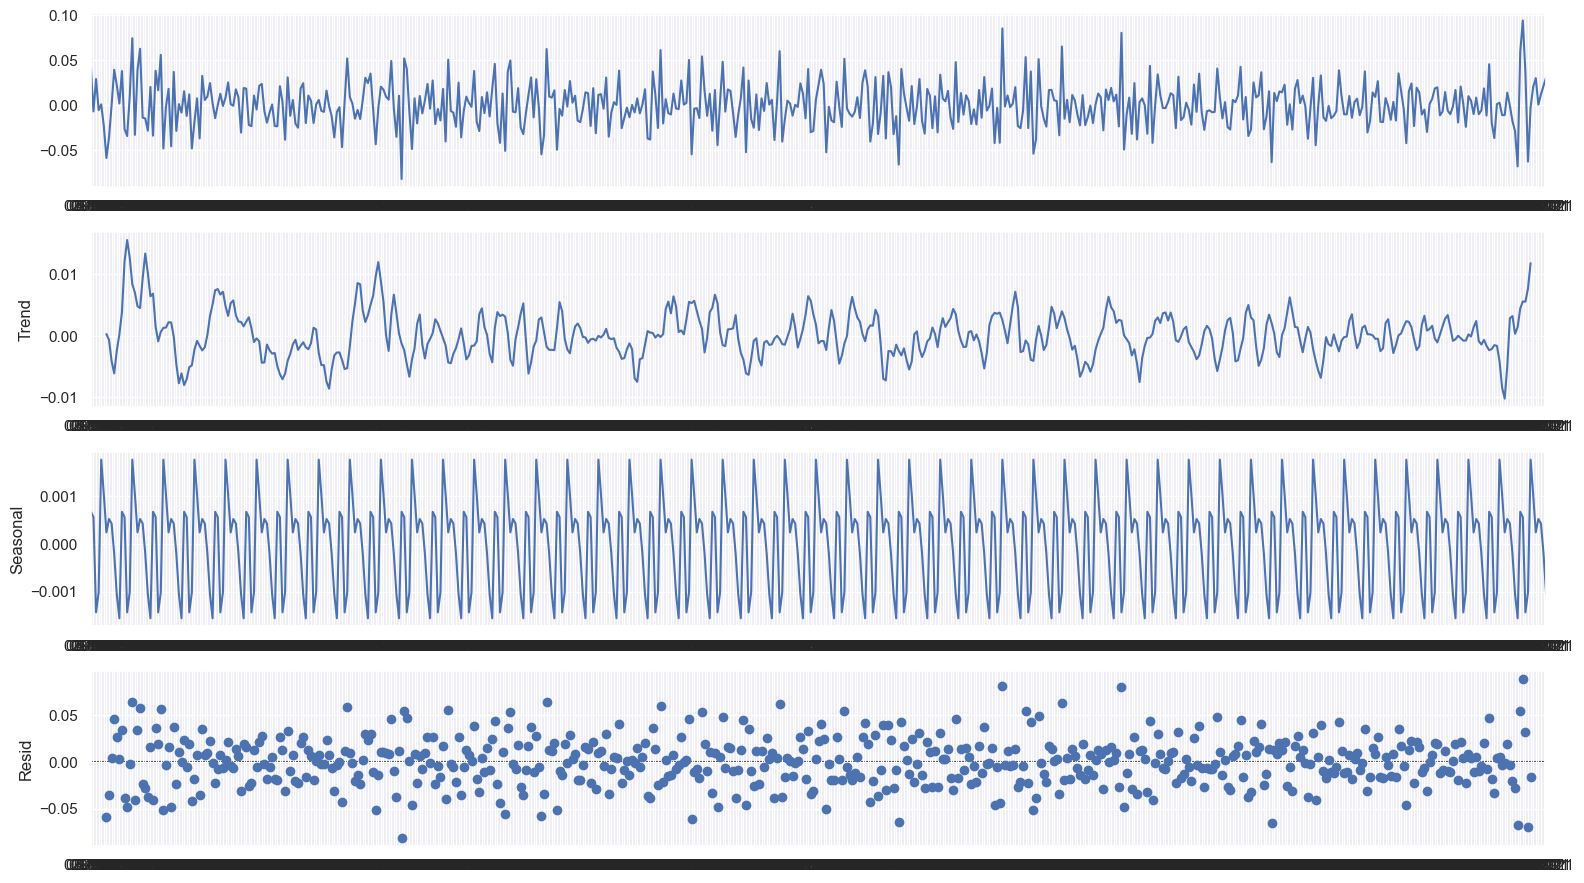

In [25]:
Decomp2 = sm.tsa.seasonal_decompose(DataDiffS2, model='additive', period=12) 
fig=Decomp2.plot()

fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

#checkup_res(Decomp2.resid)
#les residus forment un bruit blanc visuellement : Normalité + non autocorr

### Stationnarité

In [26]:
# Test ADF 
result = adfuller(DataDiffS2, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Test KPSS 
result = kpss(DataDiffS2, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.773449082836919
p-value: 2.4850964357773424e-14

KPSS Statistic: 0.156648
p-value: 0.100000


Comme nous l'avons vu lors de la double différenciation, on observe que cette dernière mène à une stationnarité claire visuellement, en comparaison avec la différenciation simple réalisée auparavant. Aussi, la p_value du test ADF est désormais de l'ordre de $10^{-14}$ donc la conclusion est d'autant plus nette. On conclut donc que l'on a bien une meilleure stationnarité de la série avec cette double différenciation.<br>
On en déduit que l'on doit partir sur le choix des paramètres $d=1$ et $D=1$, et on va donc choisir un modèle du type $SARIMA(p,1,q)(P,1,Q)_{[12]}$ pour modéliser la série temporelle.

## Modélisation 

Après avoir fait la différenciation dans la partie précédente pour éliminer la tendance saisonnière, nous avons choisi d'appliquer le modèle $SARIMA(p,1,q)(P,1,Q)_{[12]}$. Il faut désormais déterminer les autres paramètres. <br>


### Choix des paramètres 


Dans un premier temps, nous utilisons $auto$_$arima()$ pour déterminer les paramètres $p$, $q$, $P$ et $Q$, en fixant $d=1$ et $D=1$.

#### <ol><li value=1> Analyse de l'ACF et la PACF

On analyse d'abord l'ACF et la PACF de la série doublement différenciée. 

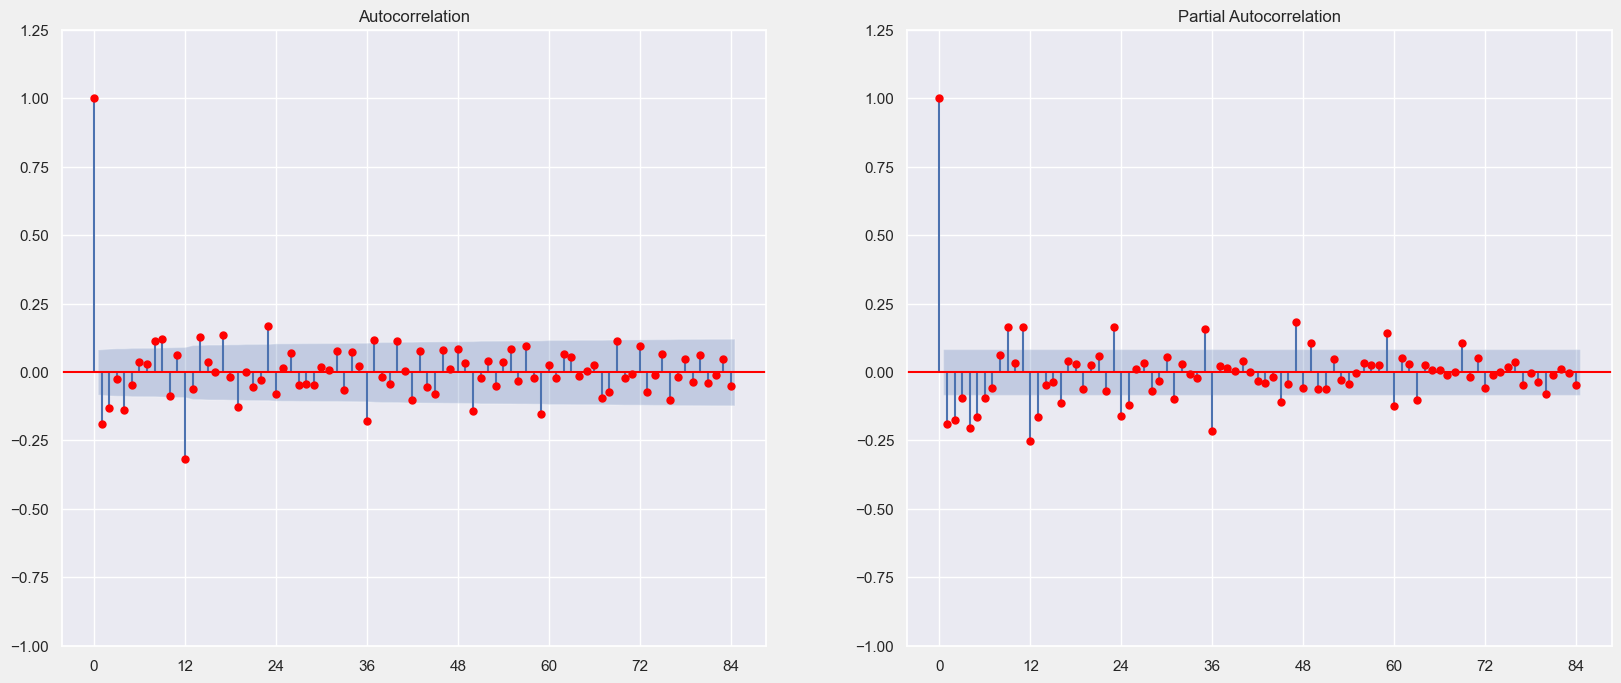

In [27]:
#Analyse de l'ACF et la PACF
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, facecolor="#F0F0F0", figsize=(20 ,8))

#ACF
plot_acf(DataDiffS2, lags=84, alpha=0.05, ax=ax1, color='red')
ax1.set_xticks(np.arange(0,86,12))
ax1.set_yticks(np.arange(-1,1.3,0.25))

#PACF
plot_pacf(DataDiffS2, lags=84, alpha=0.05, ax=ax2, color='red')
ax2.set_xticks(np.arange(0,86,12))
ax2.set_yticks(np.arange(-1,1.3,0.25))

fig.show()

Comme on peut le constater,  l'ACF montre des pics négatifs significatifs aux lags 1, 2 et 12 (composante saisonnière mensuelle).
La PACF 

#### <ol><li value=2> Application du module $auto$_$arima()$ à la série (tronquée).

In [28]:
# Application de auto_arima
model = pm.auto_arima(tsT, test='adf',
                      start_p=1, start_q=1, start_P=0,
                      max_p=5, max_q=5,
                      m=12,             
                      d=1, D=1,    # On fixe ici d=1 et D=1.    
                      seasonal=True, 
                      trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-2781.880, Time=1.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2541.665, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2637.487, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2753.654, Time=0.88 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-2610.924, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-2785.913, Time=1.45 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-2685.329, Time=0.59 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-2788.708, Time=6.21 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-2711.194, Time=2.04 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-2783.491, Time=5.77 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-2785.541, Time=6.73 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-2754.995, Time=4.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-2744.760, Time=9.56 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-2786.601, Time=12.35 sec
 ARI

In [29]:
# Résumé du résultat de auto_arima
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  576
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 12)   Log Likelihood                1401.500
Date:                              Tue, 10 Jan 2023   AIC                          -2789.000
Time:                                      22:43:24   BIC                          -2758.667
Sample:                                  01-01-1974   HQIC                         -2777.159
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4626      0.117      3.939      0.000       0.232       0.693
ma.L1         -0.7295      0.121     -6.011      0.000      -0.967      -0.492
ma.L2         -0.0786      0.067     -1.172      0.241      -0.210       0.053
ar.S.L12       0.1247      0.071      1.754      0.079      -0.015       0.264
ar.S.L24      -0.1246      0.057     -2.176      0.030      -0.237      -0.012
ma.S.L12      -0.7698      0.051    -14.976      0.000      -0.871      -0.669
sigma2         0.0004   1.93e-05     20.424      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                33.67
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.01
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cette méthode nous propose deux modèles pour la modélisation :    
- $SARIMA(1,1,1)(2,1,1)_{[12]}$
- $SARIMA(1, 1, 1)(2, 1, 2)_{[12]}$

De plus, une autre application de auto_arima nous fourni comme résultat un $SARIMA(1, 1, 2)(2, 1, 1)_{[12]}$. Nous allons donc comparer ces 3 modèles, et déterminer le meilleur pour la modélisation de la série.

#### <ol><li value=3> Comparaison des modèles de l'auto.arima

In [30]:
#SARIMA(1,1,1)(2,1,2)[12]
mod1=sm.tsa.statespace.SARIMAX(tsT, order=(1, 1, 1), seasonal_order=(2, 1, 2, 12), enforce_stationarity=False, enforce_invertibility=False)
modF1=mod1.fit()

#SARIMA(1,1,1)(2,1,1)[12]
mod2= sm.tsa.statespace.SARIMAX(tsT, order=(1, 1, 1), seasonal_order=(2, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
modF2=mod2.fit()

#SARIMA(1,1,2)(2,1,1)[12]
mod3= sm.tsa.statespace.SARIMAX(tsT, order=(1, 1, 2), seasonal_order=(2, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
modF3=mod3.fit()

##### Analyse des résidus des modèles

- Analyse graphique des résidus des modèles

In [31]:
# Représentation graphique des résidus des 3 modèles
from plotly.subplots import *

fig = make_subplots(rows=1, cols=3,subplot_titles=("Modèle 1", "Modèle 2", "Modèle 3"))
fig.add_trace(go.Scatter(y=modF1.resid, x=DataDiffS1.index, mode='lines',line=dict(color='navy', width=1)),row=1,col=1)
fig.add_trace(go.Scatter(y=modF2.resid, x=DataDiffS1.index, mode='lines',line=dict(color='purple', width=1)),row=1,col=2)
fig.add_trace(go.Scatter(y=modF3.resid, x=DataDiffS1.index, mode='lines',line=dict(color='red', width=1)),row=1,col=3)

fig.update_layout(title="Résidus",showlegend=False, height=400, width=1200,
    yaxis=dict(title_text='Valeurs',titlefont=dict(size=15),titlefont_size=16,tickfont_size=14),
    xaxis=dict(title_text="Date", titlefont=dict(size=15), tickfont_size=14),
    margin=dict(l=40, r=20, t=40, b=10),paper_bgcolor="white",plot_bgcolor="#F1F5F6")

fig.show()

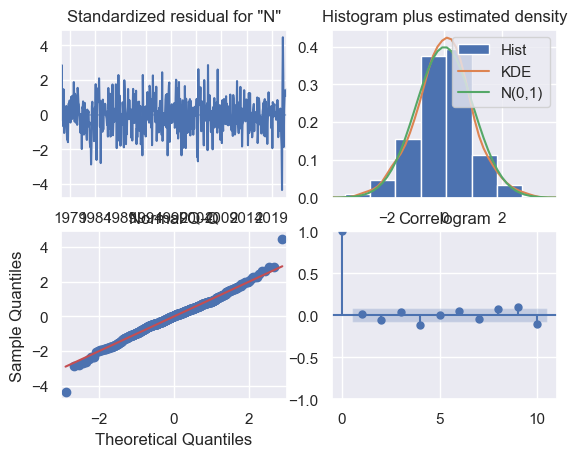

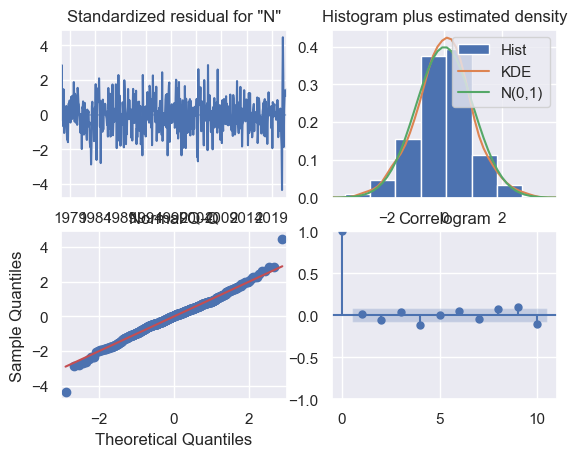

In [32]:
# Modèle 1
modF1.plot_diagnostics()

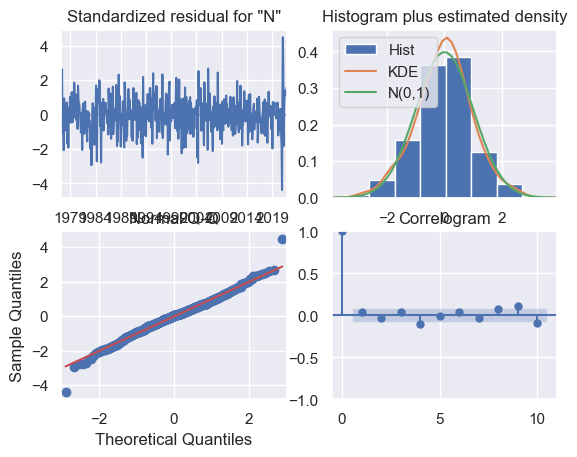

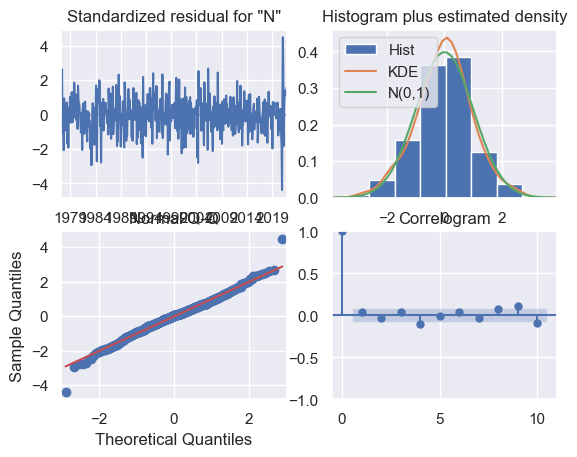

In [33]:
# Modèle 2
modF2.plot_diagnostics()

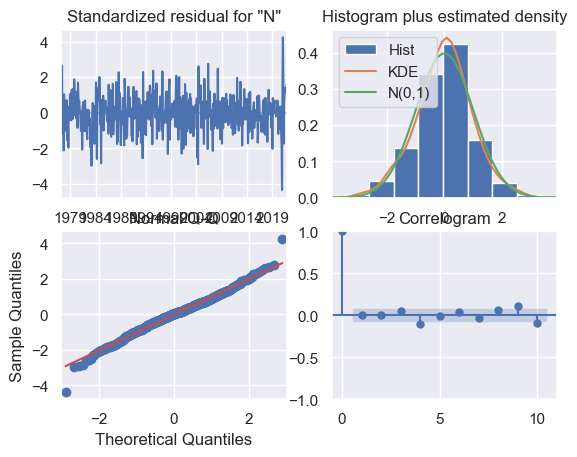

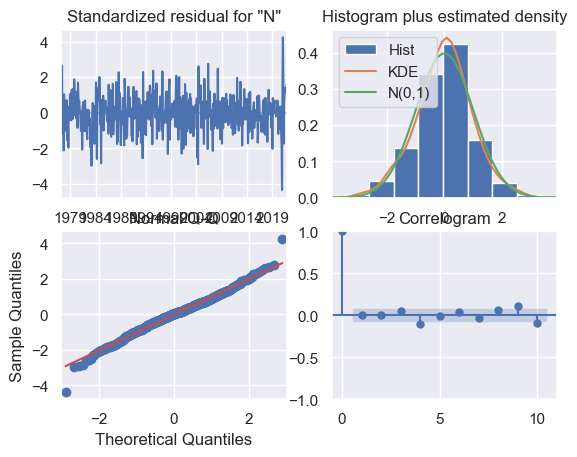

In [34]:
# Modèle 3
modF3.plot_diagnostics()

Les résultats donnés par plot_diagnostics() pour les 3 modèles sont très similaires. On s'intéresse donc à d'autres critères pour les départager.

In [35]:
def checkup_res(res):  
    """
    Fonction permettant de réaliser un checkup des résidus
    """
      
    res = res.resid    
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    ax7 = fig.add_subplot(gs[2, 2])

    # Residuals' plot
    sns.lineplot(data=res, ax=ax1).set(xlabel="", ylabel="", title='')
    
    # ACF
    plot_acf(res, ax=ax2)

    # PACF
    plot_pacf(res, ax=ax3)

    # Lag
    sns.scatterplot(x=res.values[:-1], y=res.values[1:], ax=ax4).set(xlabel=r'$\epsilon_{t-1}$', ylabel=r'$\epsilon_t$', title='Lag 1')

    # Histogramme
    sns.histplot(res / res.std(), stat="density", ax=ax5).set(title='Standardized residuals histplot', xlabel="") 
    x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
    ax5.plot(x, norm.pdf(x),'r--', label='N(0,1)')
    ax5.set_xlim(-0.5,0.5)

    # QQ plot
    qqplot(res / res.std(), line='s', ax=ax6)
    ax6.title.set_text('QQ Plot')
    
    # Série normalisée
    res_norm = (res.values - res.mean()) / res.std()
    sns.scatterplot(data=res_norm, ax=ax7).set(title="Normalised residuals", xlabel='Time')
    sns.lineplot(x=range(len(res_norm)), y=1.96, color="r", linestyle='--', ax=ax7)
    sns.lineplot(x=range(len(res_norm)), y=-1.96, color="r", linestyle='--', ax=ax7)

    # Paramètres graphiques et affichage
    plt.suptitle("Residuals' checkup")
    plt.tight_layout()
    plt.show()

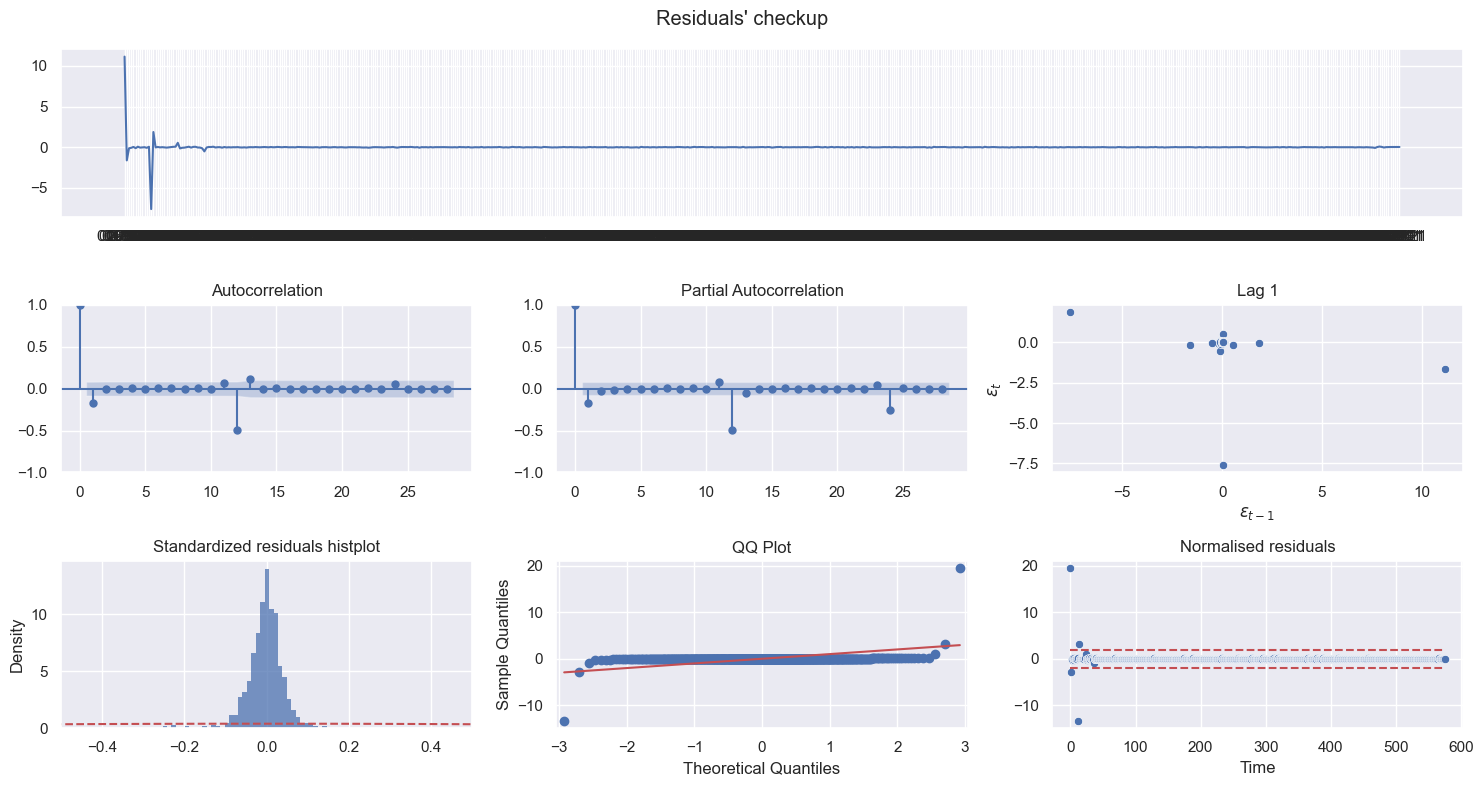

In [36]:
checkup_res(modF3) 

- Analyse via des tests et autres critères statistiques.

Test de normalité des résidus : Shapiro et Lilliefors

In [37]:
# Test de normalité de Shapiro 
print("Test de Shapiro")
print("Modèle 1 : \n statistique :",shapiro(modF1.resid).statistic, "\n p_value :",shapiro(modF1.resid).pvalue)
print("\nModèle 2 : \n statistique :",shapiro(modF2.resid).statistic, "\n p_value :",shapiro(modF2.resid).pvalue)
print("\nModèle 3 : \n statistique :",shapiro(modF3.resid).statistic, "\n p_value :",shapiro(modF3.resid).pvalue)

Test de Shapiro
Modèle 1 : 
 statistique : 0.07207965850830078 
 p_value : 0.0

Modèle 2 : 
 statistique : 0.07157564163208008 
 p_value : 0.0

Modèle 3 : 
 statistique : 0.0691763162612915 
 p_value : 0.0


In [38]:
# Test de Lilliefors de normalité : aucune différence entre les 3 modèles pour ce test
print("\nTest de Lilliefors:")

LF1 = sm.stats.diagnostic.lilliefors(modF1.resid) 
print("Norm p-val modèle 1 : ", LF1[1])

LF2= sm.stats.diagnostic.lilliefors(modF2.resid) 
print("Norm p-val modèle 2 : ", LF2[1])

LF3 = sm.stats.diagnostic.lilliefors(modF3.resid)
print("Norm p-val modèle 3 : ", LF3[1])


Test de Lilliefors:
Norm p-val modèle 1 :  0.0009999999999998899
Norm p-val modèle 2 :  0.0009999999999998899
Norm p-val modèle 3 :  0.0009999999999998899


###### Test de bruit blanc

In [39]:
# Test de Ljung-Box (test bruit blanc)
print("\nTest de bruit blanc de Ljung-Box:")

result1 = sm.stats.acorr_ljungbox(modF1.resid, lags=[72], return_df=False)
print('\nLjung-Box Statistic: %f' % result1[0][0])
print('p-value: %f' % result1[1][0])

result2 = sm.stats.acorr_ljungbox(modF2.resid, lags=[72], return_df=False)
print('\nLjung-Box Statistic: %f' % result2[0][0])
print('p-value: %f' % result2[1][0])

result3 = sm.stats.acorr_ljungbox(modF3.resid, lags=[72], return_df=False)
print('\nLjung-Box Statistic: %f' % result3[0][0])
print('p-value: %f' % result3[1][0])


Test de bruit blanc de Ljung-Box:

Ljung-Box Statistic: 141.150971
p-value: 0.000002

Ljung-Box Statistic: 179.528088
p-value: 0.000000

Ljung-Box Statistic: 171.434765
p-value: 0.000000


##### Critère AIC/BIC

In [40]:
models_aic=[modF1.aic, modF2.aic, modF3.aic]
min_aic=np.min(models_aic)
print("Modèle ayant le plus petit AIC :",models_aic.index(min_aic),"\nValeur de l'AIC du modèle :", min_aic,"\n")

Modèle ayant le plus petit AIC : 2 
Valeur de l'AIC du modèle : -2689.828298550354 



In [41]:
models_bic=[modF1.bic, modF2.bic, modF3.bic]
min_bic=np.min(models_bic)
print("Modèle ayant le plus petit BIC :",models_bic.index(min_bic),"\nValeur du BIC du modèle :", min_bic)

Modèle ayant le plus petit BIC : 1 
Valeur du BIC du modèle : -2663.929815600462


C'est le modèle 2 qui a le plus petit AIC, et le modèle 1 ayant le plus petit BIC. Ce sont donc les deux meilleurs modèles pour ces critères.

##Prédiction 

On va maintenant effectuer des prédictions sur ces deux meilleurs modèles.
On va commencer par évaluer leurs pouvoirs prédictif avec la fonction predict. Cette fonction va nous retourner pour chaque modèle son erreur de prédiction (RMSE) et un affichage graphique des prédictions et des vraies valeurs.
Puis, on va les comparer sur d'autres critères (AIC, BIC). 

### Evaluation du pouvoir prédictif 

In [42]:
def predict_plotly(model, train, test):
    """
    Evaluer le pouvoir prédictif de chaque modèle 
    """
    preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

    # On affiche l'erreur de prédiction du modele 
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))
    print("Test MAPE: %.3f" % mean_absolute_percentage_error(test, preds))

    # Affichage du graphe et des prédictions 
    pred=model.predict(start = test.iloc[0], end=test.iloc[-1], typ='levels')
    
    fig = go.Figure([
        go.Scatter(
            name='train',x=train.index.values,y=np.exp(train["Naissances"].values),
            mode='lines',line_color='#23788E',showlegend=False),
        go.Scatter(
            name='Valeurs prédites',x=test.index.values,y=np.exp(preds),
            mode='lines',marker_color="#DC4F5B"),
        go.Scatter(
            name='Valeurs réelles',x=test.index.values,y=np.exp(test["Naissances"].values),
            mode='lines',marker_color="#13B7FF"),
        go.Scatter(
            name='Lower Bound',x=test.index.values,y=np.exp(conf_int[:,0]), line_width=0, mode='lines'
            ,showlegend=False),
        go.Scatter(
            name='Upper Bound',x=test.index.values,y=np.exp(conf_int[:,1]),showlegend=False,
            line_width=0,mode='lines',fill='tonexty',opacity=0.3,fillcolor="rgba(54,117,185,0.2)") # fillcolor : couleur de l'IC à mettre en rgba pour la transparence
    ])
    fig.update_layout(title=f"Prédictions de {int(len(test)/12)} périodes (2020 et 2021) avec le premier modèle",height=500,width=1200,
        margin=dict(l=50, r=10, t=60, b=10),paper_bgcolor="white",plot_bgcolor="#EFFAFF",xaxis_title_text="Date",yaxis_title_text="Nombre de naissances",
        legend=dict(y=0.99,x=0.79))

    fig.show()

##Exemple

Superposition des prédictions et des vraies valeurs

<AxesSubplot: xlabel='Date'>

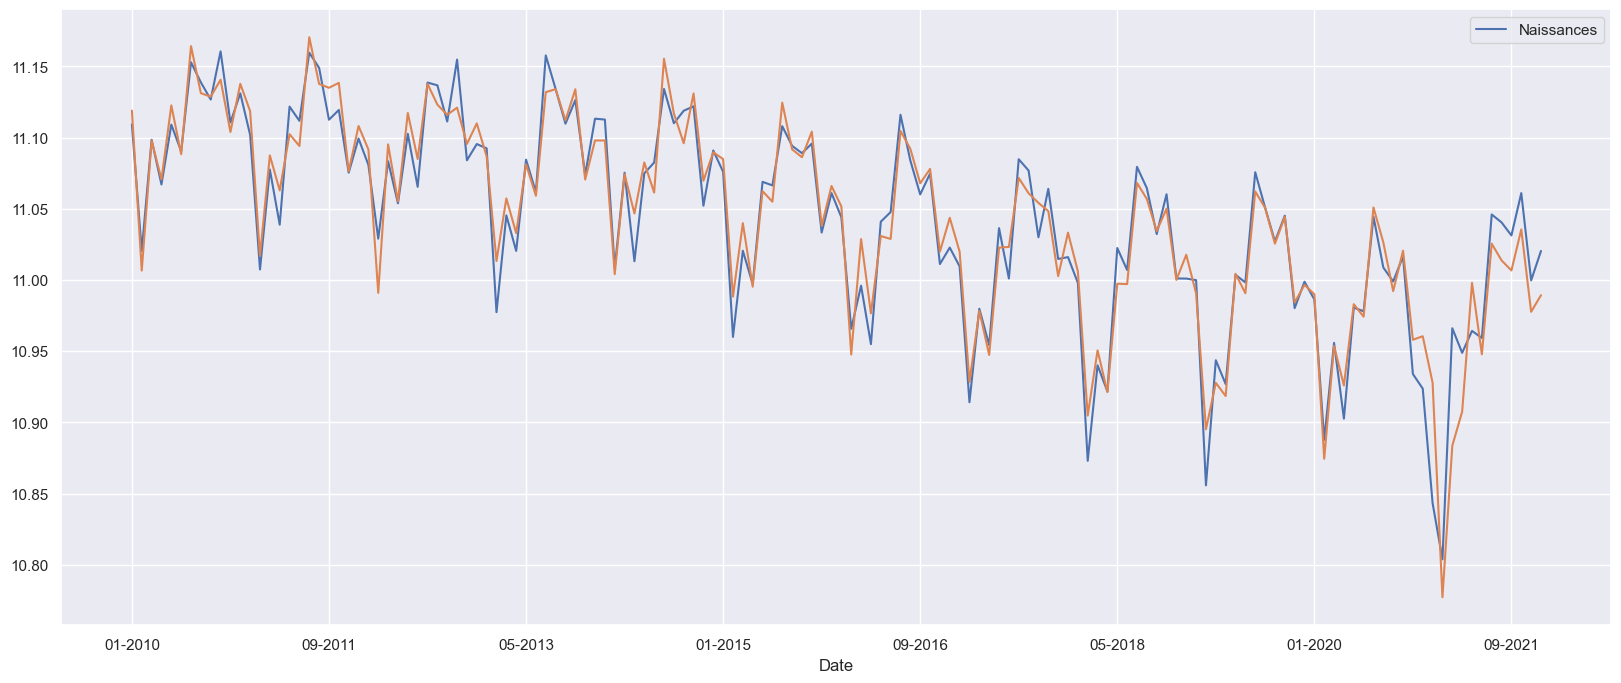

In [43]:
# Superposition des données et des fitted values à partir de 1995
#plt.plot(tsT[tsT.index >= '01-2005'])

n=len(tsT)
train=tsT
test=modF3.fittedvalues
#plt.plot(train)
tsT[len(tsT)-12*12:].plot(figsize=(20,8))
modF3.fittedvalues[len(tsT)-12*12:].plot(figsize=(20,8))

Prédiction de deux périodes 2020 et 2021

In [44]:
#model.fit(train)
n=len(tsT)
train=tsT.iloc[0:-2*12]
test=tsT[n-24:]

In [45]:
preds_df = (modF1
            .get_prediction(start=test.index[0], end=test.index[-1])
            .summary_frame(alpha=0.05)
)

In [46]:
def predict2_plotly(model, train, test, ordre):
    """
    Evaluer le pouvoir prédictif de chaque modèle 
    """
    #preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

    for i in model:
      preds_df = (i
              .get_prediction(start=test.index[0], end=test.index[-1])
              .summary_frame(alpha=0.05))
      

      # On affiche l'erreur de prédiction du modèle 
      print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds_df['mean'])))
      print("Test MAPE: %.3f" % mean_absolute_percentage_error(test, preds_df['mean']))

      # Affichage du graphe et des prédictions 
      fig = go.Figure([
          go.Scatter(
              name='Valeurs prédites',x=test.index.values,y=np.exp(preds_df['mean']),
              mode='lines',marker_color="#DC4F5B"),
          go.Scatter(
              name='Valeurs réelles',x=test.index.values,y=np.exp(test["Naissances"].values),
              mode='lines',marker_color="#13B7FF"),
          go.Scatter(
              name='Borne Inf',x=test.index.values,y=np.exp(preds_df['mean_ci_lower']), line_width=0, mode='lines'
              ,showlegend=False),
          go.Scatter(
              name='Borne Sup',x=test.index.values,y=np.exp(preds_df['mean_ci_upper']),showlegend=False,
              line_width=0,mode='lines',fill='tonexty',opacity=0.3,fillcolor="rgba(54,117,185,0.2)") # fillcolor : couleur de l'IC à mettre en rgba pour la transparence
      ])
      fig.update_layout(title=f"Prédictions de {int(len(test)/12)} périodes (2020 et 2021) avec le modèle SARIMA{ordre[model.index(i)]}[12] ",height=500,width=1200,
          margin=dict(l=50, r=10, t=60, b=10),paper_bgcolor="white",plot_bgcolor="#EFFAFF",xaxis_title_text="Date",yaxis_title_text="Nombre de naissances",
          legend=dict(y=0.99,x=0.79))

      fig.show()

In [47]:
#fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, facecolor="#F0F0F0", figsize=(20 ,8))
predict2_plotly([modF1, modF2, modF3], train, test,['(1,1,1)(2,1,2)','(1,1,1)(2,1,1)','(1,1,2)(2,1,1)'])

Test RMSE: 0.033
Test MAPE: 0.002


Test RMSE: 0.033
Test MAPE: 0.002


Test RMSE: 0.032
Test MAPE: 0.002


### Comparaison des modèles

In [48]:
# Prédictions
preds_df=[]
model=[modF1,modF2, modF3]

for i in model:
    pred=i.get_prediction(start=test.index[0], end=test.index[-1]).summary_frame(alpha=0.05)
    preds_df.append(pred)
    
# Affichage du graphe et des prédictions 
fig = go.Figure([
    go.Scatter(
        name='Valeurs prédites du premier modèle',x=test.index.values,y=np.exp(preds_df[0]['mean']),
        mode='lines',marker_color="#DC4F5B"),
    go.Scatter(
        name='Valeurs prédites du deuxième modèle',x=test.index.values,y=np.exp(preds_df[1]['mean']),
        mode='lines',marker_color="yellow"),
    go.Scatter(
        name='Valeurs réelles',x=test.index.values,y=np.exp(test["Naissances"].values),
        mode='lines',marker_color="#13B7FF"),])

fig.update_layout(title=f"Prédictions de {int(len(test)/12)} périodes (2020 et 2021) avec les 2 premiers modèles",height=500,width=1200,
    margin=dict(l=50, r=10, t=60, b=10),paper_bgcolor="white",plot_bgcolor="#EFFAFF",xaxis_title_text="Date",yaxis_title_text="Nombre de naissances",
    legend=dict(y=0.4,x=0.69))

fig.show()

## Prédiction de deux périodes supplémentaires avec le modèle choisi : 1er modèle

In [49]:
import time
#get_forecast : plus pratique que predict on peut choisir la période facilement avec steps 
pred_uc = modF3.get_forecast(steps=24)

#dataframe avec les predictions et les IC 
preds=pred_uc.summary_frame(alpha=0.05)

#Graphe
fig = go.Figure([
          go.Scatter(name='Valeurs réelles',x=tsT.index.values,y=np.exp(tsT["Naissances"].values),mode='lines',marker_color="#13B7FF"), 
          go.Scatter(name='Valeurs prédites',x=preds.index.strftime('%m-%Y',),y=np.exp(preds['mean']),mode='lines',marker_color="#DC4F5B"),
          go.Scatter(name='Borne Inf', x=preds.index.strftime('%m-%Y',), y=np.exp(preds['mean_ci_lower']), line_width=0, mode='lines', showlegend=False),
          go.Scatter(name='Borne Sup',x=preds.index.strftime('%m-%Y',), y=np.exp(preds['mean_ci_upper']), showlegend=False,
                    line_width=0, mode='lines', fill='tonexty', opacity=0.3, fillcolor="rgba(54,117,185,0.2)")
          ])

fig.update_layout(title=f"Prédictions de 2 périodes supplémentaires ",height=500,width=1200,margin=dict(l=50, r=10, t=60, b=10),
                  paper_bgcolor="white",plot_bgcolor="#EFFAFF", xaxis_title_text="Date",yaxis_title_text="Nombre de naissances", legend=dict(y=0.99,x=0.79))
fig.show()